In [138]:
# Include all traps
import festim as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

CORRECTION_FACTOR = 5e5
my_problem = F.Simulation()
thickness = 1e-3  # m
cross_sectional_area = 200  # m2
vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200),
        np.linspace(30e-9, 3e-6, num=300),
        np.linspace(3e-6, 20e-6, num=200),
        np.linspace(20e-6,thickness, num=200)

    ]
)

my_problem.mesh = F.MeshFromVertices(vertices)
V = my_problem.mesh.size * cross_sectional_area  # m3

my_problem.T = F.Temperature(500)
T_avg = 500

tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)
my_problem.materials = tungsten

R_p = 4.5e-9

my_problem.boundary_conditions = [
    F.ImplantationDirichlet(
        surfaces=[1], phi=2.5e19, R_p=R_p, D_0=tungsten.D_0, E_D=tungsten.E_D
    ),
    F.DirichletBC(surfaces=[2], value=0, field=0),
]

IC_m = F.InitialCondition(field=0, value=0)
IC_t = F.InitialCondition(field=1, value=0)
my_problem.initial_conditions = [IC_m, IC_t]

S_avg = 2.5e19 / R_p

w_atom_density = 6.3e28  # atom/m3

n_intrinsic = 1.3e-3 * w_atom_density  # atom/m3
n_ions = 4.75e25  # atom/m3
E_dt_ions = 1.15  # eV
n_neutrons_1 = 3.2e25  # atom/m3
E_dt_neutrons_1 = 1.35  # eV
n_neutrons_2 = 2.5e25  # atom/m3
E_dt_neutrons_2 = 1.65  # eV
n_neutrons_3 = 6.3e25  # atom/m3
E_dt_neutrons_3 = 1.85  # eV

my_problem.traps = [
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=0.87,
        density=n_intrinsic,
        materials=tungsten,
        id=1
    ),
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=E_dt_ions,
        density=n_ions,
        materials=tungsten,
        id=2
    ),
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=E_dt_neutrons_1,
        density=n_neutrons_1,
        materials=tungsten,
        id=3
    ),
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=E_dt_neutrons_2,
        density=n_neutrons_2,
        materials=tungsten,
        id=4
    ),
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=E_dt_neutrons_3,
        density=n_neutrons_3,
        materials=tungsten,
        id=5
    ),
]

my_problem.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-6,
    final_time=2000,
)
my_problem.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
)

total_solute = F.TotalVolume("solute", volume=1)
total_trapped = F.TotalVolume(1, volume=1)
flux_left = F.HydrogenFlux(surface=1)
flux_right = F.HydrogenFlux(surface=2)
derived_quantities = F.DerivedQuantities(
    [total_solute, total_trapped, flux_left, flux_right]
)

my_problem.exports = [derived_quantities]

my_problem.initialise()
my_problem.run()

# Build equivalent 0D model

# Compute J_out
# flux_left_interpolated = interp1d(
#     flux_left.t, flux_left.data, bounds_error=False, fill_value=flux_left.data[0]
# )

flux_right_interpolated = interp1d(
    flux_right.t, flux_right.data, bounds_error=False, fill_value=flux_right.data[0]
)
# Add a source and take only  outflux

J_out = lambda t: -cross_sectional_area *  (flux_right_interpolated(t)
)

traps = my_problem.traps.traps
k = [trap.k_0 * np.exp(-trap.E_k / F.k_B / T_avg) for trap in traps]
p = [trap.p_0 * np.exp(-trap.E_p / F.k_B / T_avg) for trap in traps]
n = [n_intrinsic, n_ions, n_neutrons_1, n_neutrons_2, n_neutrons_3]
D = tungsten.D_0*np.exp(-tungsten.E_D / F.k_B / T_avg)
residence_time = 1/(D/(thickness)**2)

def rhs(t, y):
    I_m, I_t_1, I_t_2, I_t_3, I_t_4, I_t_5 = y
    dImdt = -I_m / residence_time - sum([k[i] * I_m * (n[i] - I_t / V) for i, I_t in enumerate([I_t_1, I_t_2, I_t_3, I_t_4, I_t_5])]) + sum([p[i] * I_t for i, I_t in enumerate([I_t_1, I_t_2, I_t_3, I_t_4, I_t_5])])
    dItdt_1 = k[0] * I_m * (n[0] - I_t_1 / V) - p[0] * I_t_1 # intrinsic
    dItdt_2 = k[1] * I_m * (n[1] - I_t_2 / V) - p[1] * I_t_2  +  S_avg * (R_p * cross_sectional_area) / CORRECTION_FACTOR # ions
    dItdt_3 = k[2] * I_m * (n[2] - I_t_3 / V) - p[2] * I_t_3 # neutrons 1
    dItdt_4 = k[3] * I_m * (n[3] - I_t_4 / V) - p[3] * I_t_4 # neutrons 2
    dItdt_5 = k[4] * I_m * (n[4] - I_t_5 / V) - p[4] * I_t_5 # neutrons 3
    return [dImdt, dItdt_1, dItdt_2, dItdt_3, dItdt_4, dItdt_5]

I_m_0, I_t_1_0, I_t_2_0, I_t_3_0, I_t_4_0, I_t_5_0 = 0, 0, 0, 0, 0, 0
res = solve_ivp(
    fun=rhs,
    t_span=(0, my_problem.settings.final_time),
    y0=[I_m_0, I_t_1_0, I_t_2_0, I_t_3_0, I_t_4_0, I_t_5_0],
    t_eval=total_solute.t,
    method="Radau",
)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.0e+03 s    Ellapsed time so far: 13.1 s


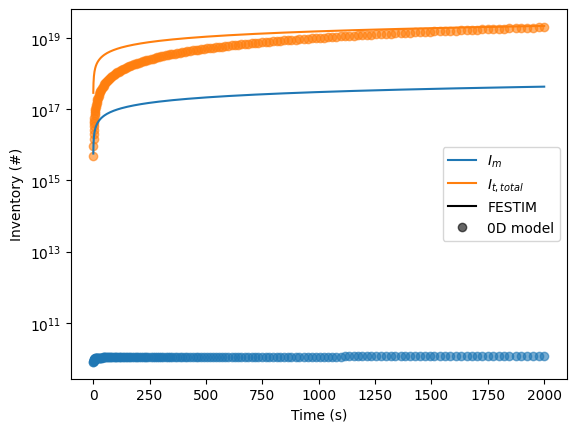

In [139]:
# Plot results
plt.figure()
plt.plot(
    total_solute.t,
    np.array(total_solute.data) * cross_sectional_area,
    color="tab:blue",
    label="$I_m$",
)
plt.plot(
    total_trapped.t,
    np.array(total_trapped.data) * cross_sectional_area,
    color="tab:orange",
    label="$I_{t,total}$",
)
plt.scatter(res.t, res.y[0], color="tab:blue", alpha=0.6)
plt.scatter(res.t, sum(res.y[1:]), color="tab:orange", alpha=0.6)

plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Inventory (#)")


custom_elements = [
    Line2D([0], [0], color="black", label="FESTIM"),
    Line2D(
        [0], [0], marker="o", linestyle="", color="black", label="0D model", alpha=0.6
    ),
]
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles + custom_elements)
plt.savefig("all_traps.png")
plt.show()


In [140]:
# Intrinsic and ion-induced traps only
import festim as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

CORRECTION_FACTOR = 1e5
my_problem = F.Simulation()
thickness = 1e-3  # m
cross_sectional_area = 200  # m2
vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200),
        np.linspace(30e-9, 3e-6, num=300),
        np.linspace(3e-6, 20e-6, num=200),
        np.linspace(20e-6,thickness, num=200)

    ]
)

my_problem.mesh = F.MeshFromVertices(vertices)
V = my_problem.mesh.size * cross_sectional_area  # m3

my_problem.T = F.Temperature(500)
T_avg = 500

tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)
my_problem.materials = tungsten

R_p = 4.5e-9

my_problem.boundary_conditions = [
    F.ImplantationDirichlet(
        surfaces=[1], phi=2.5e19, R_p=R_p, D_0=tungsten.D_0, E_D=tungsten.E_D
    ),
    F.DirichletBC(surfaces=[2], value=1e18, field=0),
]

IC_m = F.InitialCondition(field=0, value=0)
IC_t = F.InitialCondition(field=1, value=0)
my_problem.initial_conditions = [IC_m, IC_t]

S_avg = 2.5e19 / R_p

w_atom_density = 6.3e28  # atom/m3

n_intrinsic = 1.3e-3 * w_atom_density  # atom/m3
n_ions = 4.75e25  # atom/m3
E_dt_ions = 1.15  # eV
n_neutrons_1 = 3.2e25  # atom/m3
E_dt_neutrons_1 = 1.35  # eV
n_neutrons_2 = 2.5e25  # atom/m3
E_dt_neutrons_2 = 1.65  # eV
n_neutrons_3 = 6.3e25  # atom/m3
E_dt_neutrons_3 = 1.85  # eV

my_problem.traps = [
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=0.87,
        density=n_intrinsic,
        materials=tungsten,
        id=1
    ),
    F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=E_dt_ions,
        density=n_ions,
        materials=tungsten,
        id=2
    ),

]

my_problem.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-6,
    final_time=2000,
)
my_problem.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
)

total_solute = F.TotalVolume("solute", volume=1)
total_trapped = F.TotalVolume(1, volume=1)
flux_left = F.HydrogenFlux(surface=1)
flux_right = F.HydrogenFlux(surface=2)
derived_quantities = F.DerivedQuantities(
    [total_solute, total_trapped, flux_left, flux_right]
)

my_problem.exports = [derived_quantities]

my_problem.initialise()
my_problem.run()

# Build equivalent 0D model

# Compute J_out
# flux_left_interpolated = interp1d(
#     flux_left.t, flux_left.data, bounds_error=False, fill_value=flux_left.data[0]
# )

flux_right_interpolated = interp1d(
    flux_right.t, flux_right.data, bounds_error=False, fill_value=flux_right.data[0]
)
# Add a source and take only  outflux

J_out = lambda t: -cross_sectional_area *  (flux_right_interpolated(t)
)

traps = my_problem.traps.traps
k = [trap.k_0 * np.exp(-trap.E_k / F.k_B / T_avg) for trap in traps]
p = [trap.p_0 * np.exp(-trap.E_p / F.k_B / T_avg) for trap in traps]
n = [n_intrinsic, n_ions]
D = tungsten.D_0*np.exp(-tungsten.E_D / F.k_B / T_avg)
residence_time = 1/(D/(thickness)**2)

def rhs(t, y):
    I_m, I_t_1, I_t_2 = y
    dImdt =  - sum([k[i] * I_m * (n[i] - I_t / V) for i, I_t in enumerate([I_t_1, I_t_2])]) + sum([p[i] * I_t for i, I_t in enumerate([I_t_1, I_t_2])])
    dItdt_1 = k[0] * I_m * (n[0] - I_t_1 / V) - p[0] * I_t_1 # intrinsic
    dItdt_2 = k[1] * I_m * (n[1] - I_t_2 / V) - p[1] * I_t_2  +  S_avg * (R_p * cross_sectional_area) / CORRECTION_FACTOR # ions
    return [dImdt, dItdt_1, dItdt_2]


I_m_0, I_t_1_0, I_t_2_0 = 0, 0, 0
res = solve_ivp(
    fun=rhs,
    t_span=(0, my_problem.settings.final_time),
    y0=[I_m_0, I_t_1_0, I_t_2_0],
    t_eval=total_solute.t,
    method="Radau",
)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.0e+03 s    Ellapsed time so far: 1.9 s


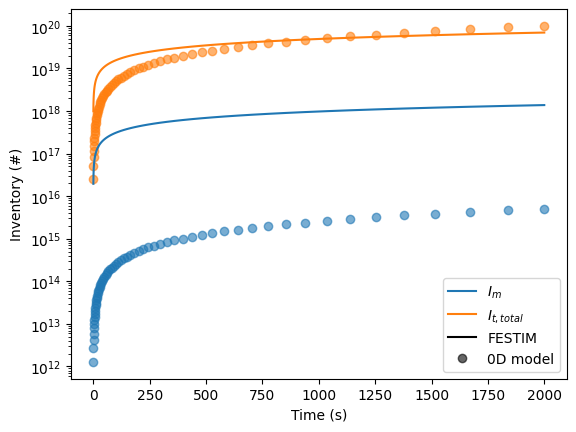

In [141]:
# Plot results

plt.figure()
plt.plot(
    total_solute.t,
    np.array(total_solute.data) * cross_sectional_area,
    color="tab:blue",
    label="$I_m$",
)
plt.plot(
    total_trapped.t,
    np.array(total_trapped.data) * cross_sectional_area,
    color="tab:orange",
    label="$I_{t,total}$",
)
plt.scatter(res.t, res.y[0], color="tab:blue", alpha=0.6)
plt.scatter(res.t, sum(res.y[1:]), color="tab:orange", alpha=0.6)

plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Inventory (#)")


custom_elements = [
    Line2D([0], [0], color="black", label="FESTIM"),
    Line2D(
        [0], [0], marker="o", linestyle="", color="black", label="0D model", alpha=0.6
    ),
]
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles + custom_elements)
plt.savefig('intrinsic_ions.png', dpi = 300)
plt.show()
